In [27]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pathlib
from tqdm.auto import tqdm
from PIL import Image

#%matplotlib inline
from IPython.display import HTML

In [28]:
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [71]:
# Root directory for dataset
dataroot = '/data2/goghgetpaper2/'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
# nz = 3*64*64 # too large?

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 128

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.00002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.7

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [30]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, x_folder, y_folder):
        self.x_dir = pathlib.Path(dataroot, x_folder)
        self.y_dir = pathlib.Path(dataroot, y_folder)
        
        self.imgs = [p.name for p in list(self.x_dir.glob('**/*.jpg'))]
        
        self.img_trans = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
            
    def __getitem__(self, index: int):
        file = self.imgs[index]
        
        x_file = pathlib.Path(self.x_dir, file)
        x = Image.open(x_file).convert('RGB')
        x = self.img_trans(x)
        
        y_file = pathlib.Path(self.y_dir, file)
        y = Image.open(y_file).convert('RGB')
        y = self.img_trans(y)

        return x, y

    def __len__(self):
        return len(self.imgs)
    
right_dataset = ImageDataset('topleft', 'topright')
print(len(right_dataset))
train_ds, val_ds = torch.utils.data.random_split(right_dataset, [400000, 40100])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
        shuffle=True, num_workers=workers)

val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size,
        shuffle=True, num_workers=workers)

440100


In [31]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [32]:
real_batch = next(iter(val_dl))
len(real_batch)

2

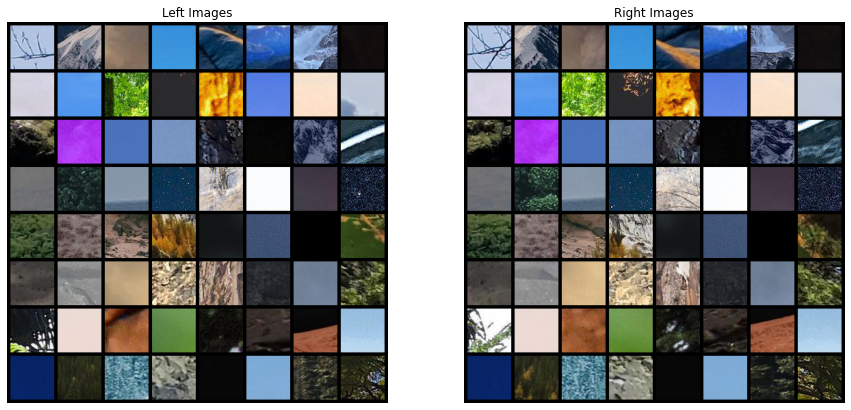

In [33]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Left Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Right Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[1].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

In [34]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [72]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=True),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 8 x 8
# #             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
# #             nn.BatchNorm2d(ndf * 8),
# #             nn.LeakyReLU(0.2, inplace=True),
# #             # state size. (ndf*8) x 4 x 4
            
# #             # ^ copied from discriminator
            
# #             # state size. (ngf*8) x 4 x 4
# #             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
# #             nn.BatchNorm2d(ngf * 4),
# #             nn.ReLU(True),
#             # state size. (ngf*4) x 8 x 8
#             nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=True),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=True),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [75]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): Tanh()
  )
)


In [76]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
# use MAE
loss_fn = torch.nn.L1Loss()

In [77]:
import pytorch_lightning as pl

class ExtendGenWrapper(pl.LightningModule):
    def __init__(self, model, 
                       criterion: nn.Module):
        super().__init__()
        self.model = model
        self.criterion = criterion 

    # Use the textGenerator forward.
    def forward(self, input_state):
        return self.model(input_state)

    # Define how we treat a batch during training.
    def training_step(self, batch, batch_idx):
        images = batch

        # Create tensor for the initial input state of the RNN.
        input_state = images[0].to(device) # Move to same device
        
        output_state = images[1].to(device)

        # Compute the predicted texts.
        predicted_image = self(input_state)

        # Use cross entropy loss.
        # However we need to collapase the batch and sequence length dimensions.

        loss = self.criterion(
            predicted_image,
            output_state
            )
        
        self.log('train_loss', loss, on_epoch = True)
        return loss

    # Very similar to training_step.
    def validation_step(self, batch, batch_idx):
        images = batch

        # Create tensor for the initial input state of the RNN.
        input_state = images[0].to(device) # Move to same device
        
        output_state = images[1].to(device)

        # Compute the predicted texts.
        predicted_image = self(input_state)


        loss = self.criterion(
            predicted_image,
            output_state
            )
        
        self.log('val_loss', loss, on_epoch = True)
        return {'val_loss': loss}
    
    def training_epoch_end(self, outputs):
        loss_mean = torch.stack([x['loss'] for x in outputs]).mean()
        print('Training loss %.2f at epoch %d' %  (loss_mean, self.current_epoch))

    def validation_epoch_end(self, outputs):
        loss_mean = torch.stack([x['val_loss'] for x in outputs]).mean()
        print('Validation loss %.2f at epoch %d' %  (loss_mean, self.current_epoch))

    def configure_optimizers(self):
        return [optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))], []

In [78]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

# Callback to save a model checkpoint (weights).
checkpoint_callback = ModelCheckpoint(
    filepath = 'weights_{epoch:03d}-{val_loss:.2f}_v3',
    verbose = True, monitor = 'val_loss', mode = 'min', save_top_k = 1)

# Create the model.
netGWrapper = ExtendGenWrapper(netG,
                                            loss_fn)

# # Simple thanks to Pytorch Lighting.
trainer = pl.Trainer(gradient_clip_val = 5.0, gpus = 1, 
                     min_epochs = 20, max_epochs = 20,
                     checkpoint_callback = checkpoint_callback,#
                     limit_train_batches = 1.0, # Use all the data.
                     weights_summary = None) 

# # Train the model
trainer.fit(netGWrapper, 
            train_dataloader = train_dl,
            val_dataloaders = [val_dl]) 

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation loss 0.53 at epoch 0


Epoch 0: val_loss reached 0.16885 (best 0.16885), saving model to /home/andrew/Repos/gogh-get-money/data/weights_epoch=000-val_loss=0.17_v3.ckpt as top 1


Validation loss 0.17 at epoch 0
Training loss 0.19 at epoch 0


Epoch 1: val_loss reached 0.16350 (best 0.16350), saving model to /home/andrew/Repos/gogh-get-money/data/weights_epoch=001-val_loss=0.16_v3.ckpt as top 1


Validation loss 0.16 at epoch 1
Training loss 0.17 at epoch 1


Epoch 2: val_loss was not in top 1


Validation loss 0.16 at epoch 2
Training loss 0.17 at epoch 2


Epoch 3: val_loss reached 0.16156 (best 0.16156), saving model to /home/andrew/Repos/gogh-get-money/data/weights_epoch=003-val_loss=0.16_v3.ckpt as top 1


Validation loss 0.16 at epoch 3
Training loss 0.17 at epoch 3


Epoch 4: val_loss was not in top 1


Validation loss 0.16 at epoch 4
Training loss 0.16 at epoch 4


Epoch 5: val_loss was not in top 1


Validation loss 0.16 at epoch 5
Training loss 0.16 at epoch 5


Epoch 6: val_loss was not in top 1


Validation loss 0.16 at epoch 6
Training loss 0.16 at epoch 6


Epoch 7: val_loss reached 0.16071 (best 0.16071), saving model to /home/andrew/Repos/gogh-get-money/data/weights_epoch=007-val_loss=0.16_v3.ckpt as top 1


Validation loss 0.16 at epoch 7
Training loss 0.16 at epoch 7


Epoch 8: val_loss reached 0.16017 (best 0.16017), saving model to /home/andrew/Repos/gogh-get-money/data/weights_epoch=008-val_loss=0.16_v3.ckpt as top 1


Validation loss 0.16 at epoch 8
Training loss 0.16 at epoch 8


Epoch 9: val_loss was not in top 1


Validation loss 0.16 at epoch 9
Training loss 0.16 at epoch 9


Epoch 10: val_loss reached 0.15954 (best 0.15954), saving model to /home/andrew/Repos/gogh-get-money/data/weights_epoch=010-val_loss=0.16_v3.ckpt as top 1


Validation loss 0.16 at epoch 10
Training loss 0.16 at epoch 10


Epoch 11: val_loss reached 0.15912 (best 0.15912), saving model to /home/andrew/Repos/gogh-get-money/data/weights_epoch=011-val_loss=0.16_v3.ckpt as top 1


Validation loss 0.16 at epoch 11
Training loss 0.16 at epoch 11


Epoch 12: val_loss was not in top 1


Validation loss 0.16 at epoch 12
Training loss 0.16 at epoch 12


Epoch 13: val_loss was not in top 1


Validation loss 0.16 at epoch 13
Training loss 0.16 at epoch 13


Epoch 14: val_loss was not in top 1


Validation loss 0.16 at epoch 14
Training loss 0.16 at epoch 14


Epoch 15: val_loss was not in top 1


Validation loss 0.16 at epoch 15
Training loss 0.16 at epoch 15


Epoch 16: val_loss reached 0.15899 (best 0.15899), saving model to /home/andrew/Repos/gogh-get-money/data/weights_epoch=016-val_loss=0.16_v3.ckpt as top 1


Validation loss 0.16 at epoch 16
Training loss 0.16 at epoch 16


Epoch 17: val_loss was not in top 1


Validation loss 0.16 at epoch 17
Training loss 0.16 at epoch 17


Epoch 18: val_loss reached 0.15873 (best 0.15873), saving model to /home/andrew/Repos/gogh-get-money/data/weights_epoch=018-val_loss=0.16_v3.ckpt as top 1


Validation loss 0.16 at epoch 18
Training loss 0.16 at epoch 18


Epoch 19: val_loss reached 0.15844 (best 0.15844), saving model to /home/andrew/Repos/gogh-get-money/data/weights_epoch=019-val_loss=0.16_v3.ckpt as top 1


Validation loss 0.16 at epoch 19
Training loss 0.16 at epoch 19



1

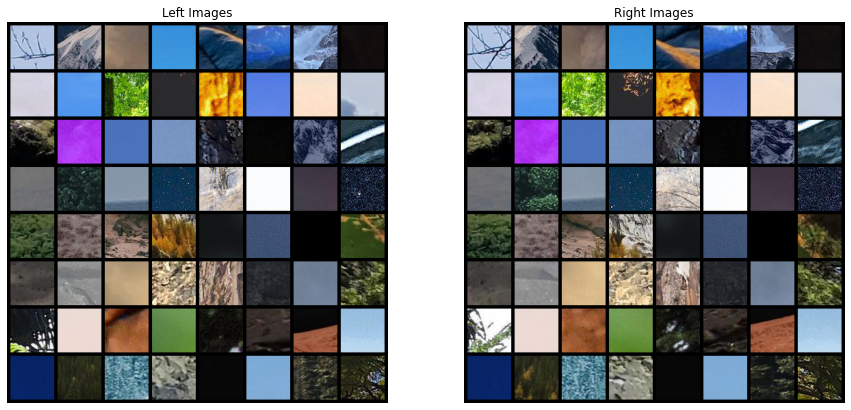

In [61]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Left Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot right images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Right Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[1].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

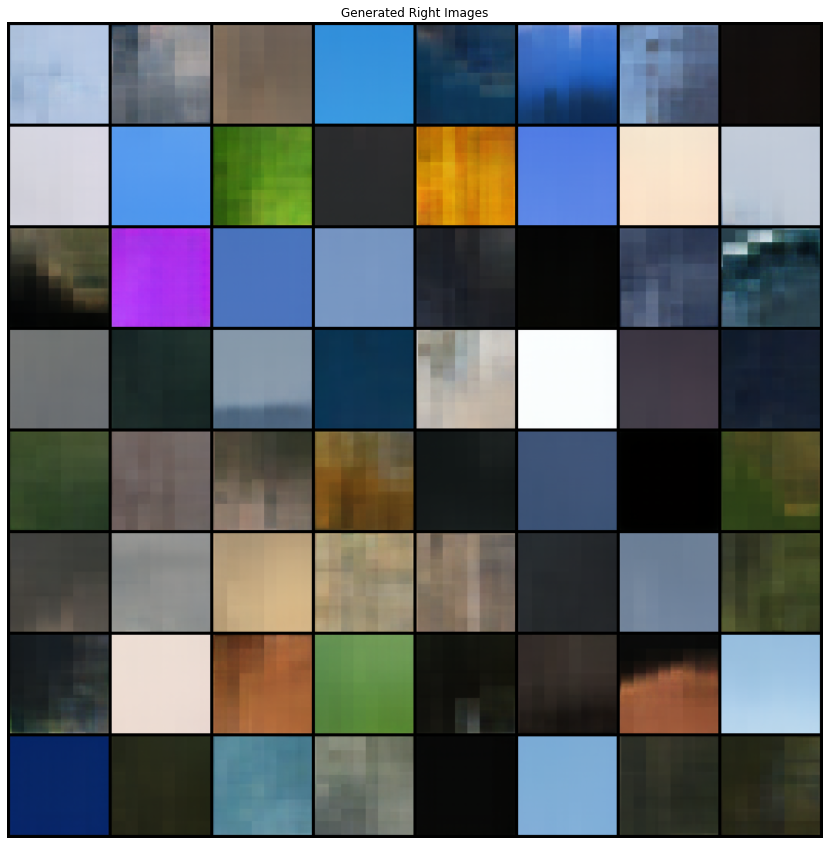

In [70]:
# Plot the fake images from the last epoch
with torch.no_grad():
    fake = netG(real_batch[0]).detach().cpu()[:64]
fake_images = vutils.make_grid(fake, padding=2, normalize=True)

# plt.subplot(1,3,3)
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Generated Right Images")
plt.imshow(np.transpose(fake_images,(1,2,0)))
plt.show()

# Loss = 1.5

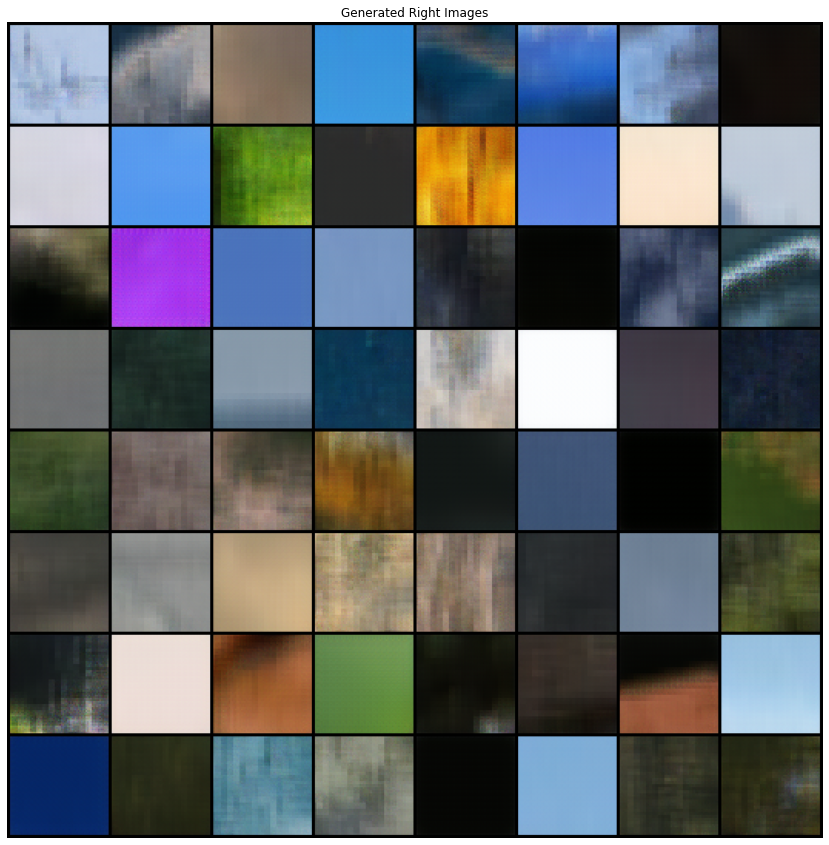

In [79]:
# Plot the fake images from the last epoch
with torch.no_grad():
    fake = netG(real_batch[0]).detach().cpu()[:64]
fake_images = vutils.make_grid(fake, padding=2, normalize=True)

# plt.subplot(1,3,3)
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Generated Right Images")
plt.imshow(np.transpose(fake_images,(1,2,0)))
plt.show()

# Loss = 1.6